In [ ]:
# !pip install --upgrade --force-reinstall torch

In [ ]:
import numpy as np
import torch
import os
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

########################### FMNIST DATASET ##################################
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Split training set into train and validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders
trainloader_fmnist = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader_fmnist = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader_fmnist = DataLoader(testset, batch_size=64, shuffle=True)


In [ ]:
dataiter = iter(trainloader_fmnist)   #To iterate through the dataset

images, labels = next(dataiter)

In [ ]:
#@title 3 layer
# 3-layer autoencoder. Initial class
class autoencoder_3(nn.Module):
    def __init__(self,dimx,  hidden1, hidden2, projected_dim): #Nlabels will be 10 in our case
        super().__init__()

        self.output1 = nn.Linear(dimx,hidden1)

        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,projected_dim)

        self.output4 = nn.Linear(projected_dim,hidden2)

        self.output5 = nn.Linear(hidden2,hidden1)

        self.output6 = nn.Linear(hidden1,dimx)

        self.relu = nn.ReLU()


    def forward(self, x):

        x = self.relu(self.output1(x))
        x = self.relu(self.output2(x))
        x = self.relu(self.output3(x))
        x = self.relu(self.output4(x))
        x = self.relu(self.output5(x))
        x = self.output6(x)

        return x



In [ ]:
# Extended class: training functionality with an MSE loss, Lasso regularization, Adam optimizer, and methods for PSNR calculation and visualizing reconstructions
class autoencoder_3_extended(autoencoder_3):

    def __init__(self,dimx, hidden1, hidden2, projected_dim,epochs=30,lr=0.001,param_lasso=0.01):

        super().__init__(dimx, hidden1, hidden2, projected_dim)  #To initialize `MLP`!

        self.lr = lr #Learning Rate

        self.param_lasso = param_lasso

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        #self.criterion = nn.NLLLoss()
        self.criterion = nn.MSELoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.loss_validation = []

    def trainloop(self,trainloader, validloader):

        # Optimization Loop

        for e in range(int(self.epochs)):

            # Random data permutation at each epoch
            # the loss is being accumulated every image

            running_loss = 0.

            for images, labels in trainloader:              # NEW w.r.t Lab 1

                self.optim.zero_grad()  #TO RESET GRADIENTS!

                decoded = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                #loss = self.criterion(decoded,labels)
                loss = self.criterion(decoded,images.view(images.shape[0], -1)) + self.param_lasso*torch.norm(self.output3.weight)

                running_loss += loss.item()

                loss.backward()
                self.optim.step()

            #Validation loss
            with torch.no_grad():
              loss_valid = 0
              for images,labels in validloader:
                decoded_val = self.forward(images.view(images.shape[0], -1))
                loss_valid += self.criterion(decoded_val ,images.view(images.shape[0], -1)) + self.param_lasso*torch.norm(self.output3.weight)
              self.loss_validation.append(loss_valid/len(validloader))


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 4 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))

    def calculate_average_psnr(self, dataloader):
        """Calculates the average PSNR for all images in the dataloader."""
        total_psnr = 0
        num_images = 0

        with torch.no_grad():  # Disable gradient calculation for inference
            for images, _ in dataloader:
                # Pasar las imágenes por el modelo
                decoded = self.forward(images.view(images.shape[0], -1))

                # Convertir los tensores a numpy para usar en la función de PSNR
                images_np = images.view(images.shape[0], -1).numpy()
                decoded_np = decoded.numpy()

                # Calcular el PSNR para cada imagen del batch
                for i in range(images_np.shape[0]):
                    psnr = peak_signal_noise_ratio(images_np[i], decoded_np[i], data_range=images_np[i].max() - images_np[i].min())
                    total_psnr += psnr
                    num_images += 1

        # Calcular el PSNR promedio
        avg_psnr = total_psnr / num_images
        return avg_psnr

    def visualize_results(self, original_images, reconstructed_images):
        """Visualiza las imágenes originales y reconstruidas."""
        plt.figure(figsize=(12, 4))
        plt.figure()

        n = len(original_images)

        for i in range(n):
            # Original images
            plt.subplot(n, 2, 2*i+1)

            # Desnormalizar la imagen para visualización
            denormalize = transforms.Normalize(mean=(-1 * 0.5 / 0.5,), std=(1.0 / 0.5,))

            original_img_den = denormalize(original_images[i])
            plt.imshow(original_img_den.squeeze().detach().numpy(), cmap='gray')
            plt.title("")

            # Reconstructed images
            plt.subplot(n, 2, 2*i+2)
            reconstructed_img_den = denormalize(reconstructed_images[i])
            plt.imshow(reconstructed_img_den.squeeze().detach().numpy(), cmap='gray')
            plt.title("")

        plt.show()



In [ ]:
# Load already trained models
autoencoder_3_15 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=15,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_3_30 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=30,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_3_50 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=50,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_3_100 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=100,epochs=20,lr=1e-3, param_lasso=0.01)

autoencoder_3_15.load_state_dict(torch.load('fmnist_autoencoder_3_15.pth'))
autoencoder_3_30.load_state_dict(torch.load('fmnist_autoencoder_3_30.pth'))
autoencoder_3_50.load_state_dict(torch.load('fmnist__autoencoder_3_50.pth'))
autoencoder_3_100.load_state_dict(torch.load('fmnist_autoencoder_3_100.pth'))

<ipython-input-25-c983559b5948>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_3_15.load_state_dict(torch.load('fmnist_autoencoder_3_15.pth'))
<ipython-input-2

<All keys matched successfully>

In [ ]:
# Training of the model for different numbers of projected dimension

autoencoder_3_15 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=15,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_3_30 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=30,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_3_50 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=50,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_3_100 = autoencoder_3_extended(dimx=784, hidden1=256, hidden2=128, projected_dim=100,epochs=20,lr=1e-3, param_lasso=0.01)

autoencoder_3_15.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')
autoencoder_3_30.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')
autoencoder_3_50.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')
autoencoder_3_100.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')




Training loss after 0 epochs: 0.128018
Training loss after 4 epochs: 0.069329
Training loss after 8 epochs: 0.063132
Training loss after 12 epochs: 0.060424
Training loss after 16 epochs: 0.058842


Training loss after 0 epochs: 0.124629
Training loss after 4 epochs: 0.064935
Training loss after 8 epochs: 0.058860
Training loss after 12 epochs: 0.055215
Training loss after 16 epochs: 0.052598


Training loss after 0 epochs: 0.129332
Training loss after 4 epochs: 0.065107
Training loss after 8 epochs: 0.058741
Training loss after 12 epochs: 0.054754
Training loss after 16 epochs: 0.052111


Training loss after 0 epochs: 0.128945
Training loss after 4 epochs: 0.066351
Training loss after 8 epochs: 0.060227
Training loss after 12 epochs: 0.056351
Training loss after 16 epochs: 0.053789




In [ ]:
# Svae models into pth file
torch.save(autoencoder_3_15.state_dict(), 'fmnist_autoencoder_3_15.pth')
torch.save(autoencoder_3_30.state_dict(), 'fmnist_autoencoder_3_30.pth')
torch.save(autoencoder_3_50.state_dict(), 'fmnist__autoencoder_3_50.pth')
torch.save(autoencoder_3_100.state_dict(), 'fmnist_autoencoder_3_100.pth')

Text(0, 0.5, 'Loss')

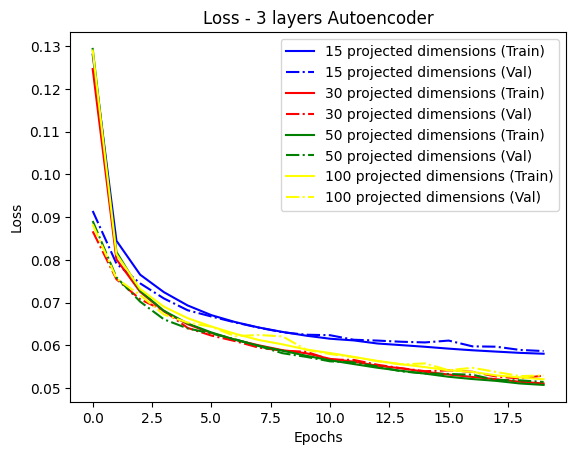

In [ ]:
plt.figure()
plt.plot(autoencoder_3_15.loss_during_training, label = '15 projected dimensions (Train)', color = 'blue')
plt.plot(autoencoder_3_15.loss_validation, label = '15 projected dimensions (Val)', linestyle = '-.', color = 'blue')
plt.plot(autoencoder_3_30.loss_during_training, label = '30 projected dimensions (Train)', color = 'red')
plt.plot(autoencoder_3_30.loss_validation, label = '30 projected dimensions (Val)', linestyle = '-.', color = 'red')
plt.plot(autoencoder_3_50.loss_during_training, label = '50 projected dimensions (Train)', color = 'green')
plt.plot(autoencoder_3_50.loss_validation, label = '50 projected dimensions (Val)', linestyle = '-.', color = 'green')
plt.plot(autoencoder_3_100.loss_during_training, label = '100 projected dimensions (Train)', color = 'yellow')
plt.plot(autoencoder_3_100.loss_validation, label = '100 projected dimensions (Val)', linestyle = '-.', color = 'yellow')

plt.title('Loss - 3 layers Autoencoder')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
psnr[3][50] = 19.88514258528


IndexError: invalid index to scalar variable.

Mean PSNR autoencoder 3 layers - projected dimension 15 output images: 19.219318978301068 dB



<Figure size 1200x400 with 0 Axes>

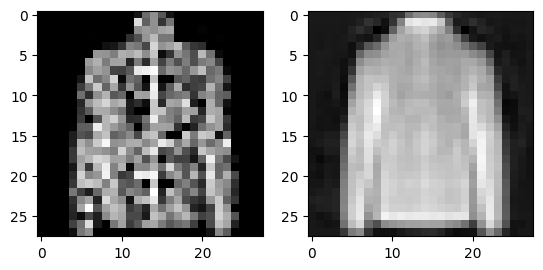

Mean PSNR autoencoder 3 layers - projected dimension 30 output images: 19.71849811493319 dB



<Figure size 1200x400 with 0 Axes>

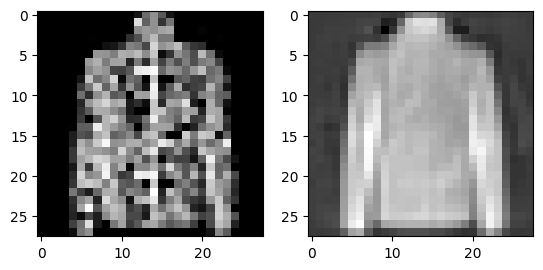

Mean PSNR autoencoder 3 layers - projected dimension 50 output images: 19.889505521999546 dB



<Figure size 1200x400 with 0 Axes>

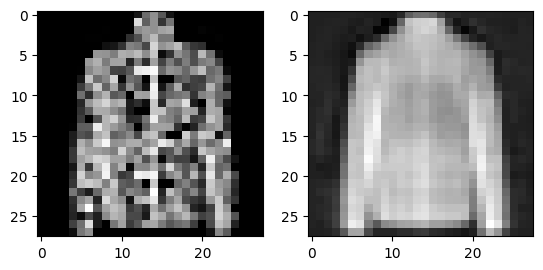

Mean PSNR autoencoder 3 layers - projected dimension 100 output images: 19.219318978928758 dB



<Figure size 1200x400 with 0 Axes>

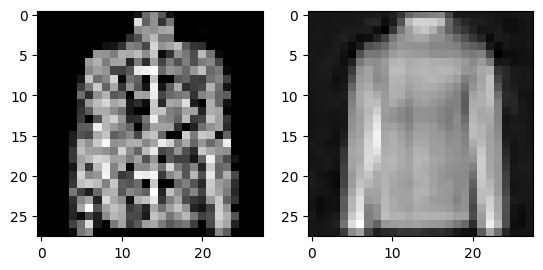

In [ ]:
# PSNR calculation and visualization of the different models
img = images.view(images.shape[0], -1)

psnr = {
    3:{
        15: None,
        30: None,
        50: None,
        100: None
    },
    5:{
        15: None,
        30: None,
        50: None,
        100: None
    }
}

decoded_3_15  = autoencoder_3_15.forward(img)
decoded_reshape_3_15 = decoded_3_15.view(decoded_3_15.shape[0], 1, 28, 28)

psnr[3][15] = autoencoder_3_15.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 3 layers - projected dimension 15 output images: ' + str(psnr[3][15]) + ' dB\n')


autoencoder_3_15.visualize_results(images[0].view(1,1,28,28),decoded_3_15[0].view(1,1,28,28))



decoded_3_30  = autoencoder_3_30.forward(img)
decoded_reshape_3_30 = decoded_3_30.view(decoded_3_30.shape[0], 1, 28, 28)

psnr[3][30] = autoencoder_3_30.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 3 layers - projected dimension 30 output images: ' + str(psnr[3][30]) + ' dB\n')

autoencoder_3_30.visualize_results(images[0].view(1,1,28,28),decoded_3_30[0].view(1,1,28,28))




decoded_3_50  = autoencoder_3_50.forward(img)
decoded_reshape_3_50 = decoded_3_50.view(decoded_3_50.shape[0], 1, 28, 28)

psnr[3][50] = autoencoder_3_50.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 3 layers - projected dimension 50 output images: ' + str(psnr[3][50]) + ' dB\n')

autoencoder_3_50.visualize_results(images[0].view(1,1,28,28),decoded_3_50[0].view(1,1,28,28))




decoded_3_100  = autoencoder_3_100.forward(img)
decoded_reshape_3_100 = decoded_3_100.view(decoded_3_100.shape[0], 1, 28, 28)

psnr[3][100] = autoencoder_3_15.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 3 layers - projected dimension 100 output images: ' + str(psnr[3][100]) + ' dB\n')

autoencoder_3_100.visualize_results(images[0].view(1,1,28,28),decoded_3_100[0].view(1,1,28,28))

Text(0, 0.5, 'PSNR (dB)')

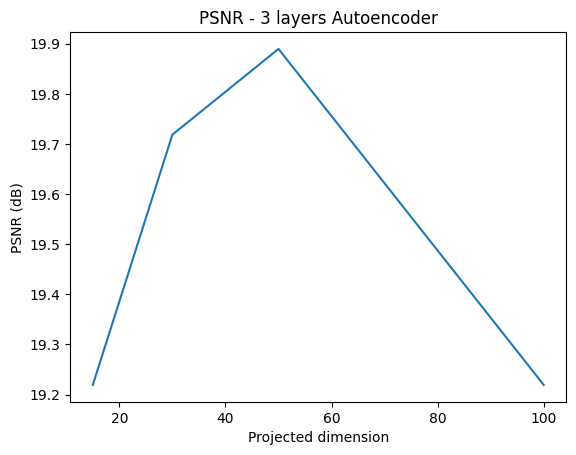

In [ ]:
plt.figure()
plt.plot(list(psnr[3].keys()), list(psnr[3].values()))
plt.title('PSNR - 3 layers Autoencoder')
plt.xlabel('Projected dimension')
plt.ylabel('PSNR (dB)')

In [ ]:
#@title 5 layers
# 5-layers autoencoder. Initial class

class autoencoder_5(nn.Module):
    def __init__(self,dimx,  hidden1, hidden2, hidden3, hidden4, projected_dim): #Nlabels will be 10 in our case
        super().__init__()

        self.output1 = nn.Linear(dimx,hidden1)

        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)

        self.output4 = nn.Linear(hidden3,hidden4)

        self.output5 = nn.Linear(hidden4,projected_dim)

        self.output6 = nn.Linear(projected_dim,hidden4)

        self.output7 = nn.Linear(hidden4,hidden3)

        self.output8 = nn.Linear(hidden3,hidden2)

        self.output9 = nn.Linear(hidden2,hidden1)

        self.output10 = nn.Linear(hidden1,dimx)

        self.relu = nn.ReLU()


    def forward(self, x):

        x = self.relu(self.output1(x))
        x = self.relu(self.output2(x))
        x = self.relu(self.output3(x))
        x = self.relu(self.output4(x))
        x = self.relu(self.output5(x))
        x = self.relu(self.output6(x))
        x = self.relu(self.output7(x))
        x = self.relu(self.output8(x))
        x = self.relu(self.output9(x))
        x = self.output10(x)

        return x



In [ ]:
# Extended class: training functionality with an MSE loss, Lasso regularization, Adam optimizer, and methods for PSNR calculation and visualizing reconstructions

class autoencoder_5_extended(autoencoder_5):

    def __init__(self,dimx, hidden1, hidden2, hidden3, hidden4, projected_dim,epochs=30,lr=0.001,param_lasso=0.01):

        super().__init__(dimx, hidden1, hidden2, hidden3, hidden4, projected_dim)  #To initialize `MLP`!

        self.lr = lr #Learning Rate

        self.param_lasso = param_lasso

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        #self.criterion = nn.NLLLoss()
        self.criterion = nn.MSELoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.loss_validation = []

    def trainloop(self,trainloader, validloader):

        # Optimization Loop

        for e in range(int(self.epochs)):

            # Random data permutation at each epoch
            # the loss is being accumulated every image

            running_loss = 0.

            for images, _ in trainloader:              # NEW w.r.t Lab 1

                self.optim.zero_grad()  #TO RESET GRADIENTS!

                decoded = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                #loss = self.criterion(decoded,labels)
                loss = self.criterion(decoded,images.view(images.shape[0], -1)) + self.param_lasso*torch.norm(self.output3.weight)

                running_loss += loss.item()

                loss.backward()
                self.optim.step()

            #Validation loss
            with torch.no_grad():
              loss_valid = 0
              for images,labels in validloader:
                decoded_val = self.forward(images.view(images.shape[0], -1))
                loss_valid += self.criterion(decoded_val ,images.view(images.shape[0], -1)) + self.param_lasso*torch.norm(self.output3.weight)
              self.loss_validation.append(loss_valid/len(validloader))



            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 4 == 0): # Every 4 epochs

                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))

    def calculate_average_psnr(self, dataloader):
        """Calculates the average PSNR for all images in the dataloader."""
        total_psnr = 0
        num_images = 0

        with torch.no_grad():  # Disable gradient calculation for inference
            for images, _ in dataloader:
                # Pasar las imágenes por el modelo
                decoded = self.forward(images.view(images.shape[0], -1))

                # Convertir los tensores a numpy para usar en la función de PSNR
                images_np = images.view(images.shape[0], -1).numpy()
                decoded_np = decoded.numpy()

                # Calcular el PSNR para cada imagen del batch
                for i in range(images_np.shape[0]):
                    psnr = peak_signal_noise_ratio(images_np[i], decoded_np[i], data_range=images_np[i].max() - images_np[i].min())
                    total_psnr += psnr
                    num_images += 1

        # Calcular el PSNR promedio
        avg_psnr = total_psnr / num_images
        return avg_psnr


    def visualize_results(self, original_images, reconstructed_images):
        """Visualiza las imágenes originales y reconstruidas."""
        plt.figure(figsize=(12, 4))
        plt.figure()

        n = len(original_images)

        for i in range(n):
            # Original images
            plt.subplot(n, 2, 2*i+1)

            # Desnormalizar la imagen para visualización
            denormalize = transforms.Normalize(mean=(-1 * 0.5 / 0.5,), std=(1.0 / 0.5,))

            original_img_den = denormalize(original_images[i])
            plt.imshow(original_img_den.squeeze().detach().numpy(), cmap='gray')
            plt.title("")

            # Reconstructed images
            plt.subplot(n, 2, 2*i+2)
            reconstructed_img_den = denormalize(reconstructed_images[i])
            plt.imshow(reconstructed_img_den.squeeze().detach().numpy(), cmap='gray')
            plt.title("")

        plt.show()



In [ ]:
# Load already trained models
autoencoder_5_15 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=15,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_5_30 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=30,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_5_50 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=50,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_5_100 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=100,epochs=20,lr=1e-3, param_lasso=0.01)

autoencoder_5_15.load_state_dict(torch.load('fmnist_autoencoder_5_15.pth'))
autoencoder_5_30.load_state_dict(torch.load('fmnist_autoencoder_5_30.pth'))
autoencoder_5_50.load_state_dict(torch.load('fmnist_autoencoder_5_50.pth'))
autoencoder_5_100.load_state_dict(torch.load('fmnist_autoencoder_5_100.pth'))

<ipython-input-14-95ed46313357>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_5_15.load_state_dict(torch.load('fmnist_autoencoder_5_15.pth'))
<ipython-input-1

<All keys matched successfully>

In [ ]:
# Train autoencoder models for different numbers of projected dimension
autoencoder_5_15 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=15,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_5_30 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=30,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_5_50 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=50,epochs=20,lr=1e-3, param_lasso=0.01)
autoencoder_5_100 = autoencoder_5_extended(dimx=784, hidden1=500, hidden2=400, hidden3=300,  hidden4=200, projected_dim=100,epochs=20,lr=1e-3, param_lasso=0.01)

autoencoder_5_15.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')
autoencoder_5_30.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')
autoencoder_5_50.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')
autoencoder_5_100.trainloop(trainloader_fmnist, valloader_fmnist)
print('\n')


Training loss after 0 epochs: 0.173233
Training loss after 4 epochs: 0.083906
Training loss after 8 epochs: 0.078240
Training loss after 12 epochs: 0.072804
Training loss after 16 epochs: 0.068613


Training loss after 0 epochs: 0.166178
Training loss after 4 epochs: 0.082473
Training loss after 8 epochs: 0.073336
Training loss after 12 epochs: 0.069324
Training loss after 16 epochs: 0.067196


Training loss after 0 epochs: 0.180100
Training loss after 4 epochs: 0.083750
Training loss after 8 epochs: 0.075375
Training loss after 12 epochs: 0.070527
Training loss after 16 epochs: 0.067869


Training loss after 0 epochs: 0.177927
Training loss after 4 epochs: 0.084543
Training loss after 8 epochs: 0.078941
Training loss after 12 epochs: 0.075874
Training loss after 16 epochs: 0.074432




In [ ]:
# Save trained models into pth file
torch.save(autoencoder_5_15.state_dict(), 'fmnist_autoencoder_5_15.pth')
torch.save(autoencoder_5_30.state_dict(), 'fmnist_autoencoder_5_30.pth')
torch.save(autoencoder_5_50.state_dict(), 'fmnist_autoencoder_5_50.pth')
torch.save(autoencoder_5_100.state_dict(), 'fmnist_autoencoder_5_100.pth')

In [ ]:
plt.figure()
plt.plot(autoencoder_5_15.loss_during_training, label = '15 projected dimensions (Train)', color = 'blue')
plt.plot(autoencoder_5_15.loss_validation, label = '15 projected dimensions (Val)', linestyle = '-.', color = 'blue')
plt.plot(autoencoder_5_30.loss_during_training, label = '30 projected dimensions (Train)', color = 'red')
plt.plot(autoencoder_5_30.loss_validation, label = '30 projected dimensions (Val)', linestyle = '-.', color = 'red')
plt.plot(autoencoder_5_50.loss_during_training, label = '50 projected dimensions (Train)', color = 'green')
plt.plot(autoencoder_5_50.loss_validation, label = '50 projected dimensions (Val)', linestyle = '-.', color = 'green')
plt.plot(autoencoder_5_100.loss_during_training, label = '100 projected dimensions (Train)', color = 'yellow')
plt.plot(autoencoder_5_100.loss_validation, label = '100 projected dimensions (Val)', linestyle = '-.', color = 'yellow')

plt.title('Loss - 5 layers Autoencoder')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

Mean PSNR autoencoder 5 layers - projected dimension 15 output images: 18.547570378202817 dB



<Figure size 1200x400 with 0 Axes>

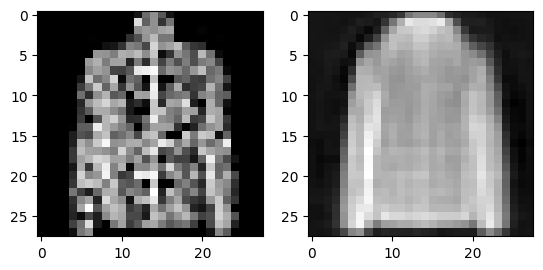

Mean PSNR autoencoder 5 layers - projected dimension 30 output images: 18.530370664548418 dB



<Figure size 1200x400 with 0 Axes>

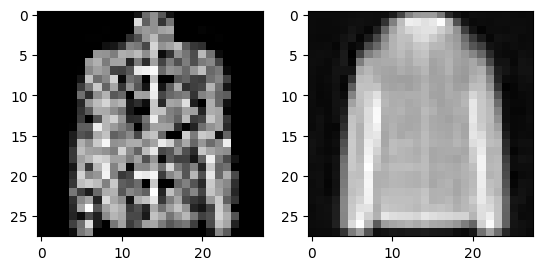

Mean PSNR autoencoder 5 layers - projected dimension 50 output images: 18.561139940973245 dB



<Figure size 1200x400 with 0 Axes>

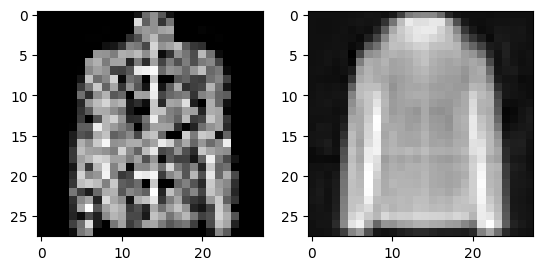

Mean PSNR autoencoder 5 layers - projected dimension 100 output images: 18.54757037802616 dB



<Figure size 1200x400 with 0 Axes>

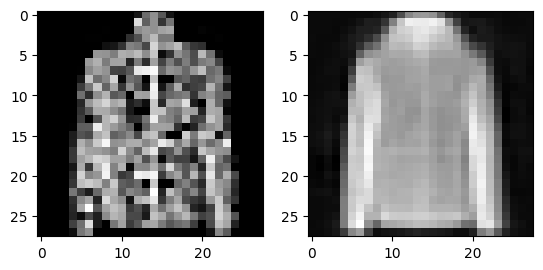

In [ ]:
# PSNR calculation and visualization of autoencoders' output images
img = images.view(images.shape[0], -1)

decoded_5_15  = autoencoder_5_15.forward(img)
decoded_reshape_5_15 = decoded_5_15.view(decoded_5_15.shape[0], 1, 28, 28)

psnr[5][15] = autoencoder_5_15.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 5 layers - projected dimension 15 output images: ' + str(psnr[5][15]) + ' dB\n')

autoencoder_5_15.visualize_results(images[0].view(1,1,28,28),decoded_5_15[0].view(1,1,28,28))



decoded_5_30  = autoencoder_5_30.forward(img)
decoded_reshape_5_30 = decoded_5_30.view(decoded_5_30.shape[0], 1, 28, 28)

psnr[5][30]  = autoencoder_5_30.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 5 layers - projected dimension 30 output images: ' + str(psnr[5][30]) + ' dB\n')

autoencoder_5_30.visualize_results(images[0].view(1,1,28,28),decoded_5_30[0].view(1,1,28,28))



decoded_5_50  = autoencoder_5_50.forward(img)
decoded_reshape_5_50 = decoded_5_50.view(decoded_5_50.shape[0], 1, 28, 28)

psnr[5][50]  = autoencoder_5_50.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 5 layers - projected dimension 50 output images: ' + str(psnr[5][50]) + ' dB\n')

autoencoder_5_50.visualize_results(images[0].view(1,1,28,28),decoded_5_50[0].view(1,1,28,28))




decoded_5_100  = autoencoder_5_100.forward(img)
decoded_reshape_5_100 = decoded_5_100.view(decoded_5_100.shape[0], 1, 28, 28)

psnr[5][100]  = autoencoder_5_15.calculate_average_psnr(testloader_fmnist)
print('Mean PSNR autoencoder 5 layers - projected dimension 100 output images: ' + str(psnr[5][100]) + ' dB\n')

autoencoder_5_100.visualize_results(images[0].view(1,1,28,28),decoded_5_100[0].view(1,1,28,28))

Text(0, 0.5, 'PSNR (dB)')

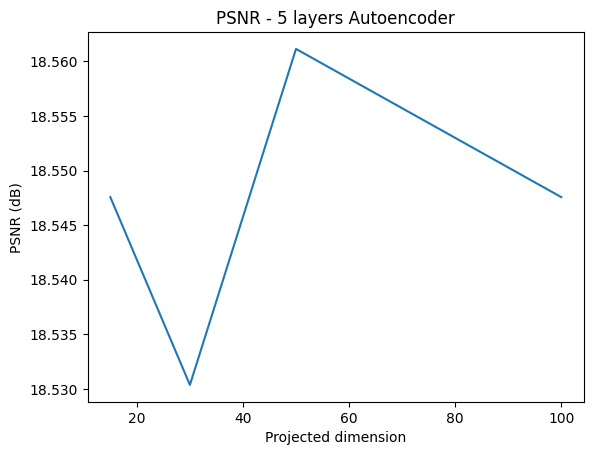

In [ ]:
plt.figure()
plt.plot(list(psnr[5].keys()), list(psnr[5].values()))
plt.title('PSNR - 5 layers Autoencoder')
plt.xlabel('Projected dimension')
plt.ylabel('PSNR (dB)')

In [ ]:
# Estimate absolute maximum PSNR (from both 3 and 5 layer autoencoders)
max_psnr = -float('inf')
max_layer = None
max_pdim = None

for layer, pdim_dict in psnr.items():
    for pdim, psnr_value in pdim_dict.items():
        if psnr_value > max_psnr:
            max_psnr = psnr_value
            max_layer = layer
            max_pdim = pdim

print(f"The max PSNR achieved is: {max_psnr} dB\n")
print(f"For the {max_layer} layers model with a projected dimension of {max_pdim}.")


The max PSNR achieved is: 19.88950552191295 dB

For the 3 layers model with a projected dimension of 50.


Text(0, 0.5, 'PSNR')

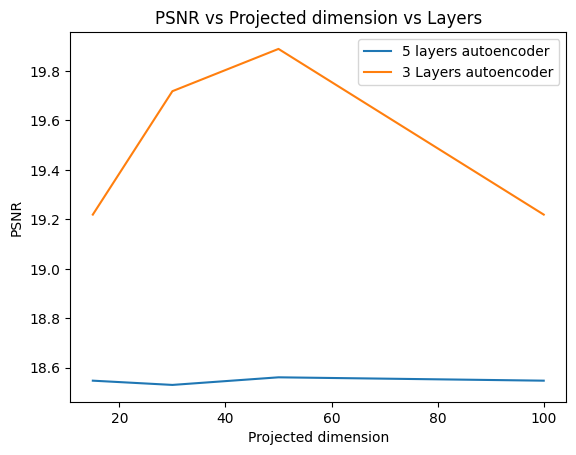

In [ ]:
# Visualization of both 3 and 5 model autoencoders PSNR
plt.figure()
plt.plot(list(psnr[5].keys()), list(psnr[5].values()), label = '5 layers autoencoder')
plt.plot(list(psnr[3].keys()), list(psnr[3].values()), label = '3 Layers autoencoder')
plt.title('PSNR vs Projected dimension vs Layers')
plt.legend()
plt.xlabel('Projected dimension')
plt.ylabel('PSNR')


In [ ]:

#@title Denoising Autoencoder

class DenoisingAutoencoder(autoencoder_3_extended):
    def __init__(self, dimx, hidden1, hidden2, projected_dim, epochs=10, lr=0.001, param_lasso=0.01):
        super().__init__(dimx, hidden1, hidden2, projected_dim, epochs, lr, param_lasso)

    def trainloop(self, trainloader, mean=0.0, std=0.1):
        """
        Training loop with Gaussian noise injection for denoising.
        - mean: mean of the Gaussian noise.
        - std: standard deviation of the Gaussian noise (square root of the variance).
        """
        for e in range(int(self.epochs)):
            running_loss = 0.0

            for images, labels in trainloader:
                self.optim.zero_grad()

                # Inject noise into the input images
                noisy_images = add_gaussian_noise(images, mean=mean, std=std)

                # Forward pass (using noisy images as input)
                decoded = self.forward(noisy_images.view(noisy_images.shape[0], -1))

                # Loss is calculated with respect to the clean images
                loss = self.criterion(decoded, images.view(images.shape[0], -1)) + self.param_lasso * torch.norm(self.output3.weight)

                running_loss += loss.item()

                # Backpropagation
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))


            if e % 1 == 0:
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}")


In [ ]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to the input images.
    - mean: mean of the Gaussian noise.
    - std: standard deviation of the noise (related to variance).
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, -1.0, 1.0)
    return noisy_images


In [ ]:
# Load already trained models
autoencoder_denoising_0p1 = DenoisingAutoencoder(dimx=784, hidden1=256, hidden2=128, projected_dim=50, epochs=20, lr=1e-3, param_lasso=0.01)
autoencoder_denoising_0p2 = DenoisingAutoencoder(dimx=784, hidden1=256, hidden2=128, projected_dim=50, epochs=20, lr=1e-3, param_lasso=0.01)
autoencoder_denoising_0p5 = DenoisingAutoencoder(dimx=784, hidden1=256, hidden2=128, projected_dim=50, epochs=20, lr=1e-3, param_lasso=0.01)
autoencoder_denoising_1 = DenoisingAutoencoder(dimx=784, hidden1=256, hidden2=128, projected_dim=50, epochs=20, lr=1e-3, param_lasso=0.01)
autoencoder_denoising_2 = DenoisingAutoencoder(dimx=784, hidden1=256, hidden2=128, projected_dim=50, epochs=20, lr=1e-3, param_lasso=0.01)

autoencoder_denoising_0p1.load_state_dict(torch.load('fmnist_autoencoder_denoising_var_0.1.pth'))
autoencoder_denoising_0p2.load_state_dict(torch.load('fmnist_autoencoder_denoising_var_0.2.pth'))
autoencoder_denoising_0p5.load_state_dict(torch.load('fmnist_autoencoder_denoising_var_0.5.pth'))
autoencoder_denoising_1.load_state_dict(torch.load('fmnist_autoencoder_denoising_var_1.pth'))
autoencoder_denoising_1.load_state_dict(torch.load('fmnist_autoencoder_denoising_var_2.pth'))

autoencoders_denoising = [autoencoder_denoising_0p1, autoencoder_denoising_0p2, autoencoder_denoising_0p5, autoencoder_denoising_1, autoencoder_denoising_2]


<ipython-input-19-ceefa7215695>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_denoising_0p1.load_state_dict(torch.load('fmnist_autoencoder_denoising_var_0.1.p

In [ ]:
# Training of models for different values of noise variance
# Define different levels of noise variance
variances = [0.1, 0.2, 0.5, 1, 2]

loss_dict = {var: None for var in variances}
psnr_dict = {var: None for var in variances}

# Analyze performance for different noise levels
for var in variances:
    autoencoder_denoising = DenoisingAutoencoder(dimx=784, hidden1=256, hidden2=128, projected_dim=50, epochs=20, lr=1e-3, param_lasso=0.01)

    std = torch.sqrt(torch.tensor(var)).item()
    print(f"Training with Gaussian noise (std={var})...")
    autoencoder_denoising.trainloop(trainloader_fmnist, mean=0.0, std=std)
    loss_dict[var] = autoencoder_denoising.loss_during_training
    torch.save(autoencoder_denoising.state_dict(), f'fmnist_autoencoder_denoising_var_{var}.pth')

    # Calculate average PSNR on test set
    avg_psnr = autoencoder_denoising.calculate_average_psnr(testloader_fmnist)
    psnr_dict[var] = avg_psnr
    print(f"Average PSNR with noise std={var}: {avg_psnr}\n")


Training with Gaussian noise (std=0.1)...
Training loss after 0 epochs: 0.13007914945483207
Training loss after 1 epochs: 0.08505952643354733
Training loss after 2 epochs: 0.07740405721465747
Training loss after 3 epochs: 0.07260480336844921
Training loss after 4 epochs: 0.06921609012782573
Training loss after 5 epochs: 0.06679107980430127
Training loss after 6 epochs: 0.06513555809358755
Training loss after 7 epochs: 0.0636213696996371
Training loss after 8 epochs: 0.06251969937980174
Training loss after 9 epochs: 0.061656037976344426
Training loss after 10 epochs: 0.06088773726423581
Training loss after 11 epochs: 0.06005921655893326
Training loss after 12 epochs: 0.05941791062057018
Training loss after 13 epochs: 0.05878037570913633
Training loss after 14 epochs: 0.0581200020412604
Training loss after 15 epochs: 0.057546328589320184
Training loss after 16 epochs: 0.05715799654026826
Training loss after 17 epochs: 0.05645503799120585
Training loss after 18 epochs: 0.05604575712482134

In [ ]:
# PSNR for the different models (Studied over noisy images with variance)
variances = [0.1, 0.2, 0.5, 1, 2]
psnr_dict = {var: None for var in variances}


j=0
# Analyze performance for different noise levels
for model in autoencoders_denoising:
  var = variances[j]
  j+=1
  total_psnr = 0
  num_images = 0

  with torch.no_grad():
    for images, _ in trainloader_fmnist:
      noisy_image = add_gaussian_noise(images, std=np.sqrt(1))
      decoded = model.forward(noisy_image.view(images.shape[0], -1))

      images_np = noisy_image.view(noisy_image.shape[0], -1).numpy()
      decoded_np = decoded.numpy()

      for i in range(images_np.shape[0]):
          psnr = peak_signal_noise_ratio(images_np[i], decoded_np[i], data_range=images_np[i].max() - images_np[i].min())
          total_psnr += psnr
          num_images += 1

  avg_psnr = total_psnr / num_images
  psnr_dict[var] = avg_psnr
  print(f"Average PSNR with noise std={var}: {avg_psnr}\n")


Average PSNR with noise std=0.1: 9.573052585020967

Average PSNR with noise std=0.2: 9.699788436698563

Average PSNR with noise std=0.5: 9.397566628084284

Average PSNR with noise std=1: 8.910552441673637

Average PSNR with noise std=2: 8.022786198754707



Text(0, 0.5, 'PSNR')

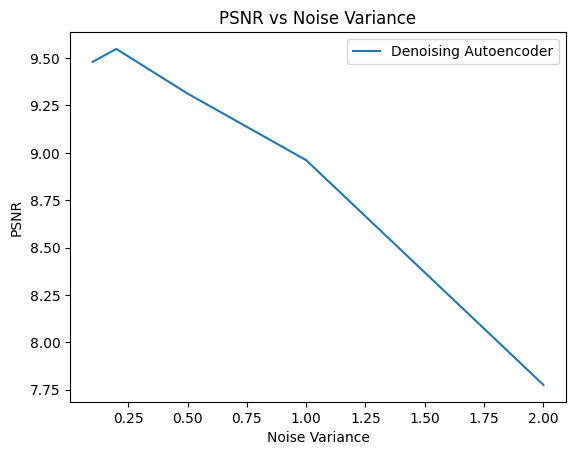

In [ ]:
plt.figure()
plt.plot(list(psnr_dict.keys()), list(psnr_dict.values()), label = 'Denoising Autoencoder')
plt.title('PSNR vs Noise Variance')
plt.legend()
plt.xlabel('Noise Variance')
plt.ylabel('PSNR')

In [ ]:
max_var = max(psnr_dict, key=psnr_dict.get)
max_psnr = psnr_dict[max_var]

print(f"Max PSNR: {max_psnr} corresponding to noise with variance {max_var}")


Max PSNR: 9.699788436698563 corresponding to noise with variance 0.2


In [ ]:
best_model_path = f'denoising_autoencoder_fmnist.pth'

autoencoder_denoising.load_state_dict(torch.load(best_model_path))

<ipython-input-110-947a4081b283>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_denoising.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

<Figure size 1200x400 with 0 Axes>

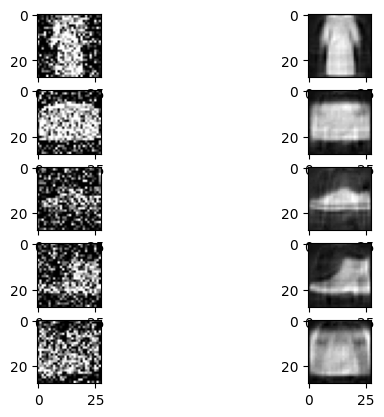

In [ ]:
# Evaluate the output images from the denoising autoencoder

# Get a batch of images from the test set
images, labels = next(iter(testloader_fmnist))

noisy_images = add_gaussian_noise(images, mean=0.0, std=1)

reconstructed_images = autoencoder_denoising.forward(noisy_images.view(noisy_images.shape[0], -1))

autoencoder_denoising.visualize_results(noisy_images[:5], reconstructed_images[:5].view(5, 1, 28, 28))
